In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
df = pd.read_csv('Meteorite_Landings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
name           45716 non-null object
id             45716 non-null int64
nametype       45716 non-null object
recclass       45716 non-null object
mass           45585 non-null float64
fall           45716 non-null object
year           45428 non-null float64
reclat         38401 non-null float64
reclong        38401 non-null float64
GeoLocation    38401 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [3]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


In [6]:
df2 = df.dropna(subset=['mass', 'year'])
df2 = df2[df2['mass']>0]

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
name           45292 non-null object
id             45292 non-null int64
nametype       45292 non-null object
recclass       45292 non-null object
mass           45292 non-null float64
fall           45292 non-null object
year           45292 non-null float64
reclat         38097 non-null float64
reclong        38097 non-null float64
GeoLocation    38097 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


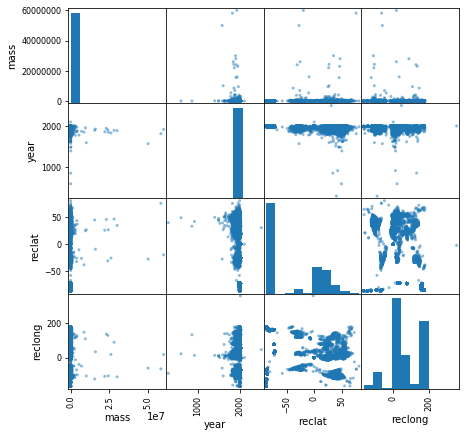

In [11]:
pd.plotting.scatter_matrix(df[['mass', 'year', 'reclat', 'reclong']],figsize=(7,7));

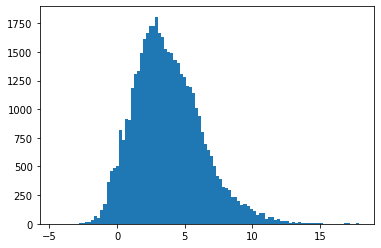

In [14]:
year = df2['year']
masses = df2['mass']
log_mass = np.log(masses) # working with logs as the masses have a very high magnitude and all of them are positive so a log
#normal distribution will characterise the mass correctly 
plt.hist(log_mass, bins=100);

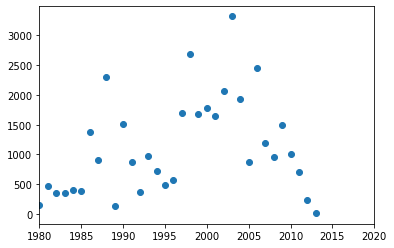

In [16]:
counts = year.value_counts()
plt.scatter(x=counts.index, y=counts)
plt.xlim(1980,2020); #only looking at the meteorites between 1980 and 2020

#year and mass are independent as asteroids are not gaining/losing weight over time 

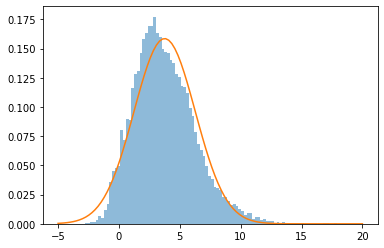

In [20]:
from scipy.stats import norm, skewnorm, lognorm 
ms = np.linspace(-5, 20, 100)
mean, std = log_mass.mean(), np.std(log_mass)
pdf_norm = norm.pdf(ms, mean, std)
plt.hist(log_mass, bins=100, density=True, alpha=0.5)
plt.plot(ms, pdf_norm);

Text(0, 0.5, 'Probability')

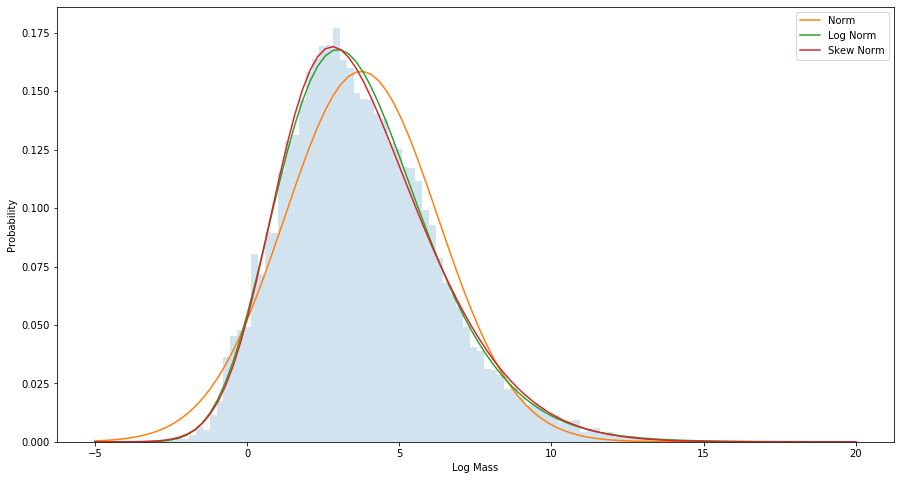

In [23]:
p_lognorm = lognorm.fit(log_mass) #parametrized log normal distribution 
pdf_lognorm = lognorm.pdf(ms, *p_lognorm)

p_skewnorm = skewnorm.fit(log_mass)
pdf_skewnorm = skewnorm.pdf(ms, *p_skewnorm)
plt.figure(figsize=(15,8))
plt.hist(log_mass, bins=100, density=True,alpha=0.2)
plt.plot(ms, pdf_norm, label='Norm')
plt.plot(ms, pdf_lognorm, label='Log Norm')
plt.plot(ms, pdf_skewnorm, label='Skew Norm')
plt.legend()
plt.xlabel('Log Mass')
plt.ylabel('Probability')

Since the log normal and the skew normal both fit the data accurately and it is difficult to tell them apart, we could use both log normal and skew normal distributions but since we have used log mass (which provides a greater advantage while using log normal aka motivation) we use log normal distribution in this case 

In case we do not have a physical motivation, we can use multiple models, propagate through them and see which model fits the best and provides the best answer

In [26]:
mass_of_doom = np.log((4/3)*np.pi*500**3*1600*1000) #assuming meteorite is a sphere 
#density of meteorite = 1600kg/m^3
#convering kg to g 
# r = 500 m (since we are concerned with 1km diameter so r=500m)
# 1000 for unit conversion 
mass_of_doom

34.36175044077777

By looking at the above plot, we have no data beyond 20 so extrapolating this distribution is a dangerous and not so accurate method. We need to come up with a more feasible model. Probably look at the mass distributrion of asteroids in the asteroid belt and correlate them with this model (advanced stuff that we do not need as of now). For now we will run with this as we are bound by the limitations of the dataset provided to us

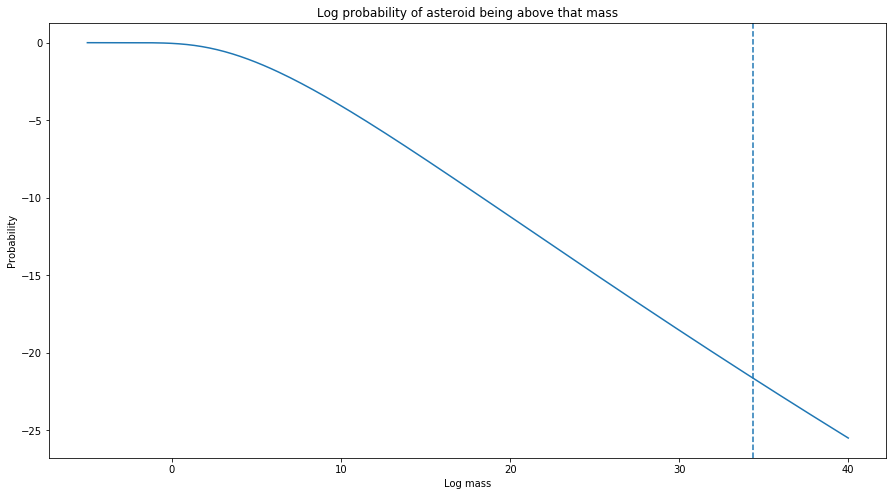

In [30]:
ms2 = np.linspace(-5, 40, 200)
plt.figure(figsize=(15,8))
plt.plot(ms2, lognorm.logsf(ms2, *p_lognorm)) #survival function of log mass is given by lognorm.logsf
plt.axvline(mass_of_doom, ls='--')
plt.xlabel('Log mass')
plt.ylabel('Probability')
plt.title('Log probability of asteroid being above that mass');

We see that the mass of doom crosses the probability survival function at -20 so the probability of the asteroid of that mass hitting the planet is e^-20 which is very very low 

## Taking time into account 

So we have here the probability of an asteroid being above a certain mass when it hits Earth. But to answer the question "What is the probability that one or more asteroids of high mass strike Earth in 1000 years?" we need to factor in the actual time component. Assume that in the next 1000 years, we predict to have $N$ impacts.

$$P(>=1\  {\rm highmass}) = 1 - P(0\ {\rm highmass}) = 1 - P(N\ {\rm not\_highmass}) = 1 - P({\rm not\_highmass})^N$$

This relies on the assumption that we know n (the number of asteroid impacts in the next 1000 years) and to solve this issue we pick up the worst case scenario (the ridiculously high value in the scatter plot of number of impacts vs year of impact)

This also has an issue as we are capturing impacts in the places where people live and not in the oceans (meteorites do fall in the oceans also but we do not have cameras over there) [also evident in the scatter matrix of reclat vs reclong] and we need to rely on simulations for that 

Imagine a similar question: Prob of getting no sixes in 5 rolls. Well its $$\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6} = \left(\frac{5}{6}\right)^5 $$
The prob of getting one or more sixes is then $1 - (5/6)^5$.

So to give a number, we need to calculate $N$ from the yearly rate, number of years, and our detection efficiency and use that with the probability that any given impact is not high mass.|

In [34]:
prob_small_mass = lognorm.logcdf(mass_of_doom, *p_lognorm) 
#we use cdf because we want to capture everything below the mass of doom from -inf to mass_of_doom
frac_sky_monitored = 0.2 #assuming that we capture only 20% of all the impacts (we are 20% efficient)
print(f'There is a fairly high chance ({np.exp(prob_small_mass)}) of a meteorite being less than the mass of doom')
num_years = 1000
num_events = num_years * counts.max() / frac_sky_monitored #((num of years concerned)*(worst case))/(efficiency)
print(f'The n that we have calculated is {num_events}')
prob_bad = 1 - np.exp(num_events * prob_small_mass) # using the formula given in the markdown 
print(f"Prob a >1km asteroid impacts with {num_years} years is {prob_bad * 100:.2f}%")

There is a fairly high chance (0.9999999995938732) of a meteorite being less than the mass of doom
The n that we have calculated is 16610000.0
Prob a >1km asteroid impacts with 1000 years is 0.67%


We have done a 1 tailed test because we assumed that the mass of the asteroids is greater than the mass of doom 